# リンク予測(DrugBank)
## ECFP -> ニューラルネットワーク

In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

In [2]:
import torch
import torch.utils.data
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # 最適化アルゴリズム実装のためのライブラリ

In [3]:
import sys
import matplotlib.pyplot as plt
from collections import Iterable

In [4]:
def f4(x):
    a = x.split(", ")
    a[0] = a[0][1]
    a[511] = a[511][0]
    a = [int(s) for s in a]
    return a

In [5]:
torch.manual_seed(1)
HSIC_epochs = 1
POST_epochs = 1

In [6]:
df_link = pd.read_csv("link_pare.csv")

In [7]:
df_nolink =pd.read_csv("nolink_pare.csv")

In [8]:
df_link.head()

,Unnamed: 0,compound_1,compound_2,smiles_1,smiles_2
0,0,DB00006,DB06605,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,DB00091,DB06605,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,DB00120,DB06605,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,DB00159,DB06605,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,DB00163,DB06605,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
df_nolink.head()

,Unnamed: 0,compound_1,compound_2,smiles_1,smiles_2
0,0,DB01452,DB11570,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,1,DB00576,DB11570,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,2,DB00669,DB11570,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,3,DB00691,DB11570,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,4,DB00401,DB11570,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [10]:
df_link = df_link.drop('Unnamed: 0', axis=1)
df_link = df_link.drop('compound_1', axis=1)
df_link = df_link.drop('compound_2', axis=1)
df_link["target"] = 1

In [11]:
df_nolink = df_nolink.drop('Unnamed: 0', axis=1)
df_nolink = df_nolink.drop('compound_1', axis=1)
df_nolink = df_nolink.drop('compound_2', axis=1)
df_nolink["target"] = 0

In [12]:
df_link.head()

,smiles_1,smiles_2,target
0,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [13]:
df_nolink.head()

,smiles_1,smiles_2,target
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
3,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0
4,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0


In [14]:
df_link_sample = df_link.sample(n= 3000)
df_nolink_sample = df_nolink.sample(n= 6000)

In [15]:
df_link_sample["smiles_1"] = df_link_sample["smiles_1"].map(f4)
df_link_sample["smiles_2"] = df_link_sample["smiles_2"].map(f4)

In [16]:
df_nolink_sample["smiles_1"] = df_nolink_sample["smiles_1"].map(f4)
df_nolink_sample["smiles_2"] = df_nolink_sample["smiles_2"].map(f4)

In [17]:
df_link_sample["smiles"] = df_link_sample["smiles_1"] + df_link_sample["smiles_2"]

In [18]:
df_nolink_sample["smiles"] = df_nolink_sample["smiles_1"] + df_nolink_sample["smiles_2"]

In [19]:
df_link_sample = df_link_sample.drop('smiles_1', axis=1)
df_link_sample = df_link_sample.drop('smiles_2', axis=1)

In [20]:
df_nolink_sample = df_nolink_sample.drop('smiles_1', axis=1)
df_nolink_sample = df_nolink_sample.drop('smiles_2', axis=1)

In [21]:
df = pd.concat([df_link_sample, df_nolink_sample])

In [22]:
df = df.sample(frac=1)

In [23]:
df.tail()

,target,smiles
583783,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
925257,1,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1300281,0,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
393709,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1196336,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
X = df["smiles"].values.tolist()
y = df["target"].values.tolist()

In [25]:
def kernel_matrix(x : torch.Tensor, sigma):
    dim = len(x.size())
    x1  = torch.unsqueeze(x, 0)
    x2  = torch.unsqueeze(x, 1)
    axis= tuple(range(2, dim+1))
    if dim > 1:
        return torch.exp( -0.5 * torch.sum(torch.pow(x1-x2, 2), axis=axis) / sigma**2)
    else:
        return torch.exp( -0.5 * torch.pow(x1-x2, 2) / sigma**2)

In [26]:
def test_kernel(sigma=0.5):
    x   = np.random.rand(100,10)
    x   = torch.from_numpy(x)
    mat = kernel_matrix(x, sigma)
    print(mat.size(), "supposed to be (100,100)")
    x   = np.random.rand(100,128,128)
    x   = torch.from_numpy(x)
    mat = kernel_matrix(x, sigma)
    print(mat.size(), "supposed to be (100,100)")

In [27]:
def HSIC(Kx, Ky, m):
    xy = torch.matmul(Kx, Ky)
    h  = torch.trace(xy) / m**2 + torch.mean(Kx)*torch.mean(Ky) - 2 * torch.mean(xy)/m
    return h*(m/(m-1))**2 

In [48]:
class HSICBottleneck:
    def __init__(self, model, batch_size, lambda_0, sigma, multi_sigma=None,lr=0.01):   
        # self.model      = model
        self.model      = Extractor(model)
        self.batch_size = batch_size
        self.lambda_0   = lambda_0
        self.sigma      = sigma
        self.extractor  = 'hsic'
        # self.trainable  = []
        self.lr         = lr
        self.multi_sigma = multi_sigma
        assert isinstance(self.multi_sigma, Iterable) if  multi_sigma is not None else True
        
        self.opt = optim.RMSprop(self.model.parameters(), lr)
        # self.opt = optim.SGD(self.trainable, lr)
        self.remember = []
        
    def step(self, input_data, labels):
        Kx  = kernel_matrix(input_data, self.sigma)
        Ky = kernel_matrix(labels, self.sigma)
        
        total_loss = 0.
        
        y_pred, hidden_zs = self.model(input_data)
        
        for name, layer in self.model.named_children():
            if self.extractor in name:
                hidden_z = hidden_zs[name]
                Kz = kernel_matrix(hidden_z, self.sigma)
                loss = HSIC(Kz, Kx, self.batch_size) - self.lambda_0*HSIC(Kz,Ky, self.batch_size)
                total_loss += loss      
        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()
        
        self.remember.append(total_loss.item())
                
        return total_loss.item()

    def multi_sigma_step(self, input_data, labels):
        # TODO
        if self.multi_sigma is None:
            return self.step(input_data, labels)
        Kx = []
        Ky = []
        
        for sigma in self.multi_sigma:
            Kx.append(kernel_matrix(input_data, self.sigma))
            Ky.append(kernel_matrix(labels, self.sigma))
        
        total_loss = 0.
        
        y_pred, hidden_zs = self.model(input_data)
        
        for name, layer in self.model.named_children():
            #TODO
            if self.extractor in name:
                hidden_z = hidden_zs[name]
                Kz = []
                for sigma in self.multi_sigma:
                    Kz.append(kernel_matrix(hidden_z, self.sigma))
                loss = 0.
                for i in range(len(self.multi_sigma)):
                    loss += HSIC(Kz[i], Kx[i], self.batch_size) - self.lambda_0*HSIC(Kz[i], Ky[i], self.batch_size)
                total_loss += loss
        
        self.opt.zero_grad()
        total_loss.backward()
        self.opt.step()
        
        self.remember.append(total_loss.item())
                
        return total_loss.item()

In [29]:
class Net(nn.Module):  # 多層ニューラルネットワークの構築
    def __init__(self):
        super(Net, self).__init__()
        self.hsic1 = nn.Linear(1024, 128)  # 一つ目の隠れ層のユニット数は512
        self.hsic2 = nn.Linear(128, 128)  # 二つ目の隠れ層のユニット数は128
        self.output_layer = nn.Linear(128, 1)  # 出力層のユニット数は1
        self.f = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.hsic1(x))  # 活性化関数にはReLUを使用
        x = F.relu(self.hsic2(x))  # 活性化関数にはReLUを使用
        x = self.f(self.output_layer(x))
        return x

In [30]:
class Extractor(nn.Module):
    def __init__(self, model : nn.Module):
        super(Extractor, self).__init__()
        self.extractor_pre = 'hsic'
        self.all_layers = []
        for name, layer in model.named_children():
            setattr(self, name, layer)
            self.all_layers.append(name)
        # set all_layers to tuple, fix its order
        self.all_layers = tuple(self.all_layers)
    
    
    def forward(self, data):
        x = data
        hidden = {}
        for name in self.all_layers:
            name : str
            layer = getattr(self,name)
            x = layer(x)
            if name.startswith(self.extractor_pre):
                hidden[name] = x
        return x, hidden

In [31]:
class PostTrained:
    def __init__(self, model : nn.Module, criterion,lr=0.1):
        parameters = []
        model.train()
        for name, layer in model.named_children():
            if name == "output_layer":
                for params in layer.parameters():
                    parameters.append(params)
            else:
                for params in layer.parameters():
                    params.requires_grad = False
        self.opt   = optim.RMSprop(parameters, lr)
        self.model = model
        self.lr    = lr
        self.criterion = criterion

    def step(self, input_data, labels):
        output_data = self.model(input_data)
        loss = self.criterion(output_data, labels)
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
        return loss.item()

In [32]:
df = df.reset_index(drop=True)

In [33]:
df['target'] = df['target'].astype(float)

In [34]:
def f5(x):
    ans = [x]
    return ans

In [35]:
df["target"] = df["target"].map(f5)

In [59]:
df.tail()

,target,smiles
8995,[0.0],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
8996,[1.0],"[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8997,[0.0],"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
8998,[0.0],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8999,[0.0],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [60]:
train_label = torch.tensor(df["target"])
train_data = torch.tensor(df["smiles"]).float()

In [61]:
train_tensor = torch.utils.data.TensorDataset(train_data,train_label)
train_dataset, test_dataset = torch.utils.data.random_split(train_tensor, [8100, 900])

In [62]:
num_train = 8100
X_train = train_data[:num_train, :]
y_train = train_label[:num_train]
X_test  = train_data[num_train:, :]
y_test  = train_label[num_train:]

In [40]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [63]:
net = Net()

In [73]:
net.train()

Net(
  (hsic1): Linear(in_features=1024, out_features=128, bias=True)
  (hsic2): Linear(in_features=128, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (f): Sigmoid()
)

In [65]:
# HSIC training
batch_size = 30
hsic = HSICBottleneck(net, batch_size=30, lambda_0=100., sigma=10.)

In [66]:
# Post training
criterion = nn.BCELoss()
post = PostTrained(net, criterion=criterion)

In [74]:
print(net.hsic2.weight)

Parameter containing:
tensor([[ 0.0230,  0.0870,  0.0797,  ...,  0.0228,  0.0309,  0.0746],
        [ 0.0311,  0.0707, -0.0094,  ...,  0.0440,  0.0217,  0.0115],
        [ 0.0500,  0.0215,  0.0567,  ..., -0.0356,  0.0669,  0.0688],
        ...,
        [ 0.0079, -0.0109,  0.0177,  ...,  0.0469,  0.0259,  0.0054],
        [-0.0234,  0.0191, -0.0420,  ...,  0.0819, -0.0877,  0.0831],
        [ 0.0275,  0.0005,  0.0442,  ...,  0.0429,  0.0817,  0.0255]])


In [69]:
for epoch in range(POST_epochs):
    print("===============================")
    print("POST EPOCH %d" % epoch)
    index = np.arange(len(X_train))
    np.random.shuffle(index)
    X_train = X_train[index]
    y_train = y_train[index]
    for batch in range(0, int(num_train/batch_size)):    
        data_x = X_train[batch*batch_size : (batch+1)*batch_size]
        label  = y_train[batch*batch_size : (batch+1)*batch_size]
        loss = post.step(data_x, label)
        if batch % 50 == 0:
            sys.stdout.write("%6.6f =>" % loss)
            sys.stdout.flush()
    sys.stdout.write('\n')

POST EPOCH 0
0.670847 =>0.725767 =>0.498074 =>0.517062 =>0.672730 =>0.584289 =>


In [68]:
for epoch in range(HSIC_epochs):
    print("===============================")
    print("EPOCH %d" % epoch)
    index = np.arange(len(X_train))
    np.random.shuffle(index)
    X_train = X_train[index]
    y_train = y_train[index]
    for batch in range(0, int(num_train/batch_size)):    
        data_x = X_train[batch*batch_size : (batch+1)*batch_size]
        label  = y_train[batch*batch_size : (batch+1)*batch_size]
        loss = hsic.step(data_x, label)
        print(net.hsic2.weight)
        if batch % 50 == 0:
            sys.stdout.write("%6.6f =>" % loss)
            sys.stdout.flush()
    sys.stdout.write('\n')

EPOCH 0


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

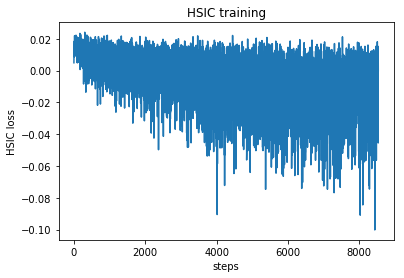

In [84]:
plt.plot(range(len(hsic.remember)), hsic.remember)
plt.title("HSIC training")
plt.xlabel("steps")
plt.ylabel("HSIC loss")
plt.show()

In [66]:
criterion = nn.CrossEntropyLoss()  # 学習の際、目的関数として最小二乗誤差を使用
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)

In [67]:
lambda1, lambda2 = 0.5, 0.0001

In [68]:
for epoch in range(100):
    total_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()  
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(total_loss)
print('\n学習が終了しました。')

165.53337568044662
161.6426222026348
160.77498707175255
159.33175602555275
157.57573175430298
154.7887009382248
150.94664308428764
146.68290588259697
142.86310425400734
138.98705819249153
135.33774119615555
132.40708389878273
128.7234246134758
125.70318508148193
123.40079939365387
120.06290704011917
117.79582041501999
114.93729010224342
113.72906136512756
110.08629597723484
107.11555400490761
104.15519452095032
101.13679194450378
97.33972245454788
93.74697649478912
90.24445976316929
85.33102042973042
80.40722939372063
75.91301377862692
69.3564913123846
64.81314455717802
59.482806131243706
54.19736801832914
48.12395265698433
42.625624395906925
37.94654984399676
33.165444135665894
29.188407763838768
24.70116152986884
21.709437573328614
18.34405061043799
16.206519735977054
13.926681185141206
12.792874235659838
10.652331514284015
9.637538207694888
8.350876832846552
7.481267114169896
6.9325678162276745
6.098331451881677
5.625443570315838
4.969209176953882
4.551031407434493
4.168612722307444

In [72]:
correct = 0.0  # 正答数を表す
total = 0.0  # テストデータの総数を表す
link = 0.0
for data in test_loader:
    inputs, labels = data
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)  # テストデータの総数を計算
    correct += (predicted == labels).sum().item()  # 正答数を計算
    link += (1 == labels).sum().item()

In [75]:
print('テストデータに対する正答率： %d / %d = %f' % (correct, total, correct / total) + '\n')
print('テストデータに含まれるリンクありの割合： %d / %d = %f' % (link, total, link / total) + '\n')
print('テストデータに含まれるリンクなしの割合： %d / %d = %f' % (total - link, total, (total- link) / total) + '\n')

dataiter = iter(test_loader)
for i in range(4):  # テストデータの一部を4行に分けて可視化
    images, labels = dataiter.next()
    print("ラベル：" + "".join('%5s' % labels[j].item() for j in range(8)))  # ラベルの値を表示

    _, predict = torch.max(net(images).data, 1)  # テストデータに対する予測を出力
    print("　予測：" + "".join('%5s' % predict[j].item() for j in range(8)) + "\n")  # 予測結果を表示

テストデータに対する正答率： 675 / 900 = 0.750000

テストデータに含まれるリンクありの割合： 291 / 900 = 0.323333

テストデータに含まれるリンクなしの割合： 609 / 900 = 0.676667

ラベル：    1    0    1    1    0    0    0    0
　予測：    0    0    0    0    0    0    0    0

ラベル：    0    0    0    0    1    0    0    0
　予測：    0    1    0    0    0    0    1    1

ラベル：    1    1    0    1    0    1    0    0
　予測：    1    1    0    1    0    1    0    0

ラベル：    0    0    0    0    1    0    1    0
　予測：    1    0    0    0    1    0    0    0

